In [1]:
from acfunctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from IPython.display import Image, display, HTML
import starspot as ss
import starspot.rotation_tools as rt
from starspot import sigma_clipping
import lightkurve as lk
from lightkurve import search_targetpixelfile, search_lightcurvefile
import math
import exoplanet
import eleanor
from astropy.coordinates import SkyCoord
from scipy import interpolate
from tess_kep_funct import *
from tqdm import tqdm
from scipy import misc
from bokeh.models import ColumnDataSource, LabelSet, Whisker
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df

import warnings
warnings.filterwarnings("ignore")

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
with open('tess_period.data', 'rb') as filehandle:
    short_tess_period = pickle.load(filehandle) 

In [5]:
with open('tess_periods_interp.data', 'rb') as filehandle:
    tess_periods_interp = pickle.load(filehandle) 

In [6]:
with open('ls_periods_interp.data', 'rb') as filehandle:
    ls_period_interp = pickle.load(filehandle) 

In [7]:
with open('ls_period_no_interp.data', 'rb') as filehandle:
    ls_period_no_interp = pickle.load(filehandle) 

In [8]:
#dataset with tess vs kepler IDs
tess_kep = pd.read_csv('data_summary.csv')
tess_short = tess_kep[tess_kep.tess_ffi == True]
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

In [9]:
#importing McQ periods
headers = 'TIC ID', 'KIC ID', 'McQ Periods';  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [10]:
# converting txt file data to arrays
kic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    kic_ids.append(int(rot_table[index][1]))
    mcq_periods.append(float(rot_table[index][2]))

In [11]:
# selecting shortest periods only (<13 days, half a tess cycle)
short_periods = []
kics_short_periods = []

for index, period in enumerate(mcq_periods):
    if period < 13: 
        short_periods.append(period)
        kics_short_periods.append(kic_ids[index])
        
#limiting to the first 60
#short_periods = short_periods[0:61]
#tics_short_periods = tics_short_periods[0:61]

In [12]:
def find_m_b(x,y,err): #analytical approach to finding line of best fit 
    #C     
    errorsq = np.square(err)
    C = np.diag(errorsq)

    #A 
    xb = ([1] * len(x))
    mata = []
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
    A= np.matrix(mata).reshape((len(x), 2))

    #plugging in 
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)

    m = float(cov[0])
    b = float(cov[1])
    return m ,b 

def residuals(x, y, error): #residual abundance function
    mborig = find_m_b(x, y, error)
    m = mborig[0]
    b = mborig[1]

    predicted_values = [] #y values from slope
    pv = 0
    for u in x:
        pv = (m*u) + b
        predicted_values.append(pv)
        pv = 0

    prev = np.array(predicted_values)
    abu = np.array(y)
    diff = abu - prev #difference between slope and measured values  
    return diff

# test 

In [13]:
figure_kep = combining_PDC_quarters(kics_short_periods[0])
flux_kep = figure_kep[0]
time_kep = figure_kep[1]
flux_error_kep = figure_kep[2]

    
resid = residuals(time_kep, flux_kep, flux_error_kep)
resid = resid[~np.isnan(resid)]
time = time_kep[~np.isnan(resid)]

   
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

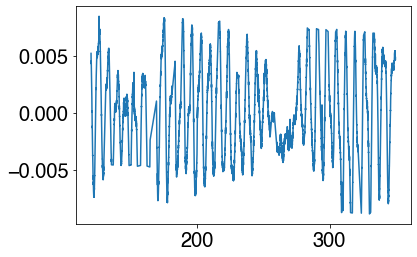

In [14]:
plt.plot(time, resid)

100%|██████████| 1000/1000 [00:01<00:00, 730.17it/s]


6.896615934652531 6.908108108108109 6.999999999997613


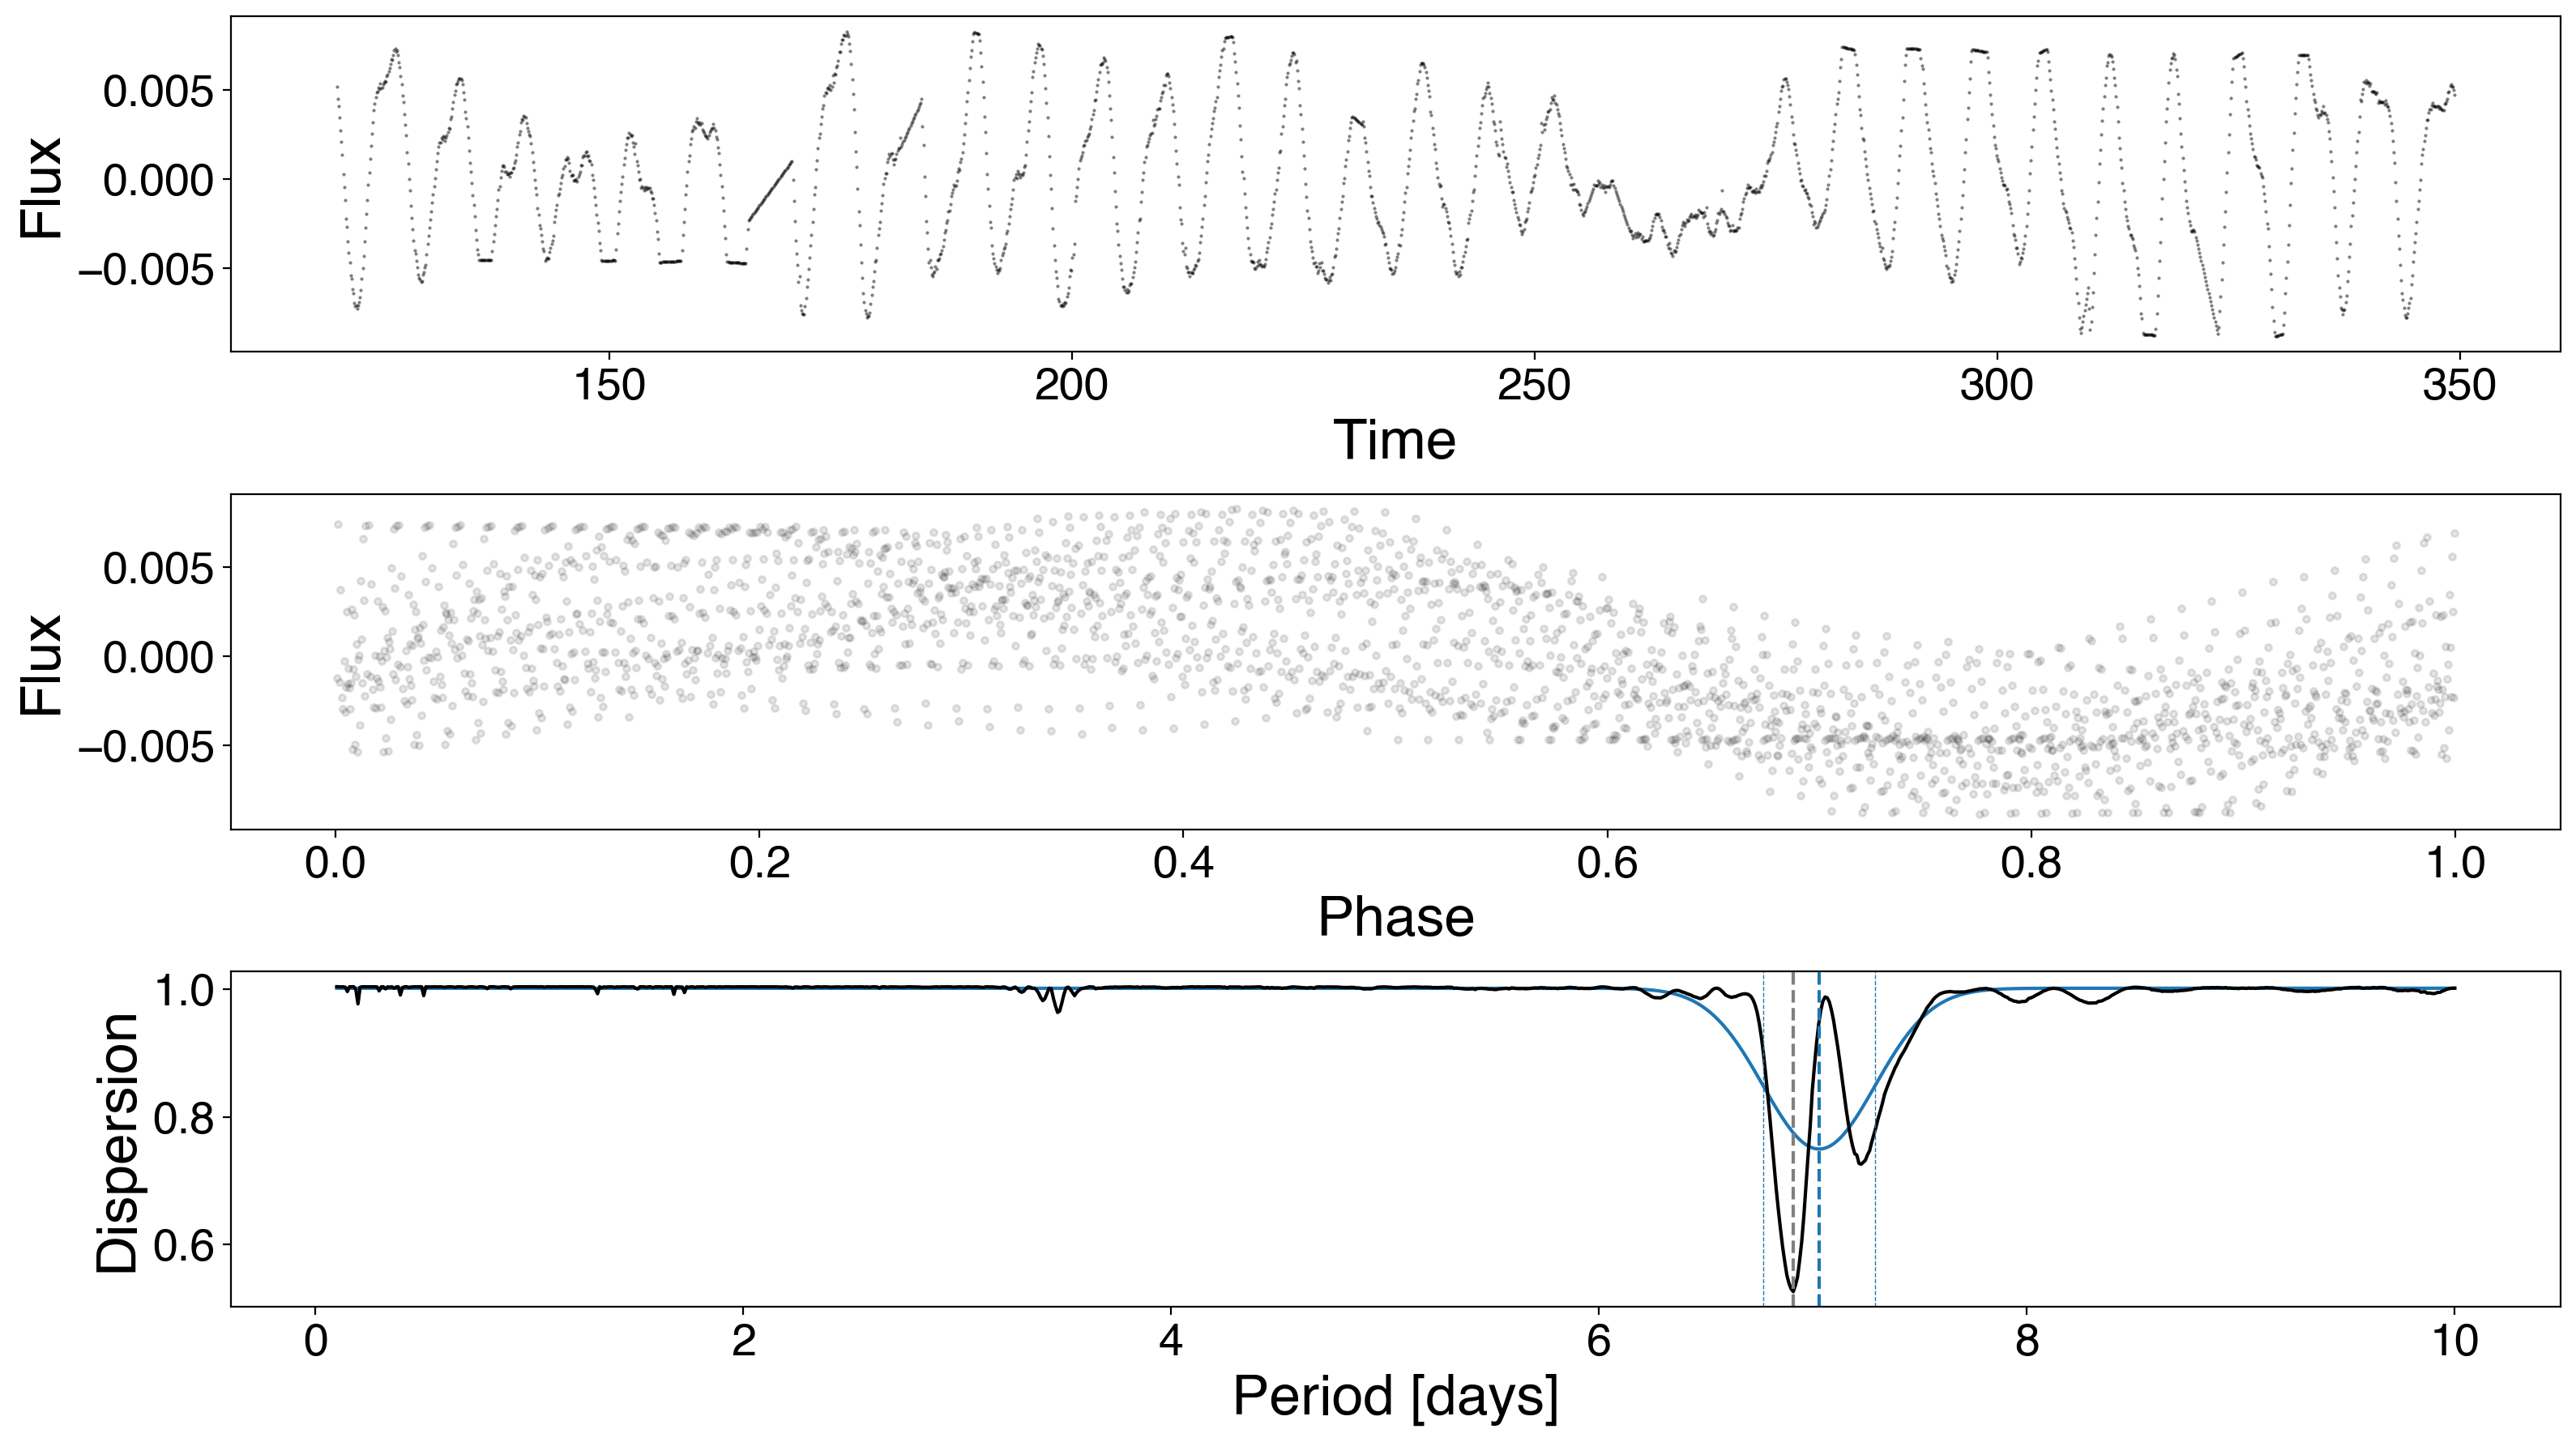

In [15]:
rotate_el = ss.RotationModel(xnew, flux, flux_err)
ls_period = rotate_el.ls_rotation()
    
period_grid = np.linspace(.1, 10, 1000)
pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)
pdm_plot = rotate_el.pdm_plot();

ex_1 = exoplanet.autocorr_estimator(xnew, flux, yerr=flux_err, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
    
print(ls_period, pdm_period, exo_period)

# all kep stars 

In [16]:
ls_kep_resid = []
pdm_kep_resid = []
pdm_kep_error = []
exo_kep_resid = []
exo_kep_error = []
error_kep = []

for each, kic in enumerate(kics_short_periods[0:61]): 
    figure_kep = combining_PDC_quarters(kic)
    flux_kep = figure_kep[0]
    time_kep = figure_kep[1]
    flux_error_kep = figure_kep[2]
    
    index = np.where(np.array(kics_short_periods) == kic)
    mcq_period = short_periods[index[0][0]]
    
    resid = residuals(time_kep, flux_kep, flux_error_kep)
    resid = resid[~np.isnan(resid)]
    time = time_kep[~np.isnan(resid)]


    try :
        #linear interpolation
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)
    
    
        #exoplanet's ac function
        ex_1 = exoplanet.autocorr_estimator(xnew, flux, yerr=flux_err, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_error = ex_1['peaks'][0]['period_uncert']
        exo_kep_resid.append(exo_period)
        exo_kep_error.append(exo_error)
        
        #lomb-scargle 
        rotate_el = ss.RotationModel(xnew, flux, flux_err)
        ls_period = rotate_el.ls_rotation()
        
        #pdm 
        period_grid = np.linspace(.1, 10, 1000)
        pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)
         
        ls_kep_resid.append(ls_period)
        pdm_kep_resid.append(pdm_period)
        pdm_kep_error.append(period_err)
        print('works!')
        
        
    except : 
        print('error')
        error_kep.append(each)
        ls_kep_resid.append(0)
        pdm_kep_resid.append(0)
        pdm_kep_error.append(0)
        exo_kep_resid.append(0)
        exo_kep_error.append(0)

100%|██████████| 1000/1000 [00:01<00:00, 678.63it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 445.90it/s]


fitting to a limited range
works!


100%|██████████| 1000/1000 [00:02<00:00, 408.73it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 501.92it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 388.33it/s]


works!


100%|██████████| 1000/1000 [00:03<00:00, 331.98it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 421.00it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 408.44it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 461.71it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 516.98it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 373.56it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 652.44it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 488.04it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 505.98it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 512.61it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 511.07it/s]


works!


100%|██████████| 1000/1000 [00:03<00:00, 318.17it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 415.60it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 402.69it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 390.87it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 480.64it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 406.26it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 477.74it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 627.61it/s]


fitting to a limited range
works!


100%|██████████| 1000/1000 [00:03<00:00, 295.80it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 383.65it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 376.60it/s]


works!


100%|██████████| 1000/1000 [00:03<00:00, 251.65it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 394.34it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 505.34it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 374.75it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 513.53it/s]


works!


100%|██████████| 1000/1000 [00:04<00:00, 219.69it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 469.02it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 385.16it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 479.92it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 603.66it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 513.08it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 688.11it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 389.37it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 538.86it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 364.39it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 501.61it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 409.68it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 430.41it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 483.87it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 520.70it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 519.64it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 542.34it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 421.74it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 539.87it/s]


works!


100%|██████████| 1000/1000 [00:03<00:00, 314.88it/s]


works!


100%|██████████| 1000/1000 [00:03<00:00, 254.84it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 405.45it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 441.15it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 609.41it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 582.98it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 454.91it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 440.77it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 426.26it/s]


works!


100%|██████████| 1000/1000 [00:03<00:00, 332.01it/s]


works!


with open('ls_kep_resid.data', 'wb') as filehandle:
    pickle.dump(ls_kep_resid, filehandle)

with open('pdm_kep_resid.data', 'wb') as filehandle:
    pickle.dump(pdm_kep_resid, filehandle)

with open('exo_kep_resid.data', 'wb') as filehandle:
    pickle.dump(exo_kep_resid, filehandle)

with open('pdm_kep_error.data', 'wb') as filehandle:
    pickle.dump(pdm_kep_error, filehandle)

with open('exo_kep_error.data', 'wb') as filehandle:
    pickle.dump(exo_kep_error, filehandle)

with open('error_kep.data', 'wb') as filehandle:
    pickle.dump(error_kep, filehandle)

In [13]:
with open('exo_kep_error.data', 'rb') as filehandle:
    exo_kep_error = pickle.load(filehandle) 

In [14]:
with open('ls_kep_resid.data', 'rb') as filehandle:
    ls_kep_resid = pickle.load(filehandle) 

In [15]:
with open('pdm_kep_resid.data', 'rb') as filehandle:
    pdm_kep_resid = pickle.load(filehandle) 

In [16]:
with open('exo_kep_resid.data', 'rb') as filehandle:
    exo_kep_resid = pickle.load(filehandle) 

In [17]:
with open('pdm_kep_error.data', 'rb') as filehandle:
    pdm_kep_error = pickle.load(filehandle) 

In [18]:
with open('error_kep.data', 'rb') as filehandle:
    error_kep = pickle.load(filehandle) 

In [19]:
print(exo_kep_error)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [20]:
mcq_exo_difference = []
for each, value in enumerate(short_periods[0:61]):
    diff = np.abs(exo_kep_resid[each] - value)
    mcq_exo_difference.append(diff)    

In [21]:
x =  short_periods[0:61]
y = mcq_exo_difference

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = mcq_exo_difference, 
    kep = (cat['kic_id'])[0:61],
    tess = (cat['tic_id'])[0:61]))

mcq_exo_diff_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[-6, 6], title="Difference Between Kepler ExoACF with Trends Removed and McQuillan Periods",
   x_axis_label='McQuillan Period', y_axis_label='Period Difference', plot_width=900)

mcq_exo_diff_plot.line(x, 0, name = "x=0", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
mcq_exo_diff_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)


mcq_exo_diff_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("Kep", "$kep"),
    ("TESS", "$tess")] 

show(mcq_exo_diff_plot)

In [22]:
with open('mcq_exo_difference.data', 'wb') as filehandle:
    pickle.dump(mcq_exo_difference, filehandle)

In [23]:
x = short_periods[0:51]
y =  pdm_kep_resid

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = pdm_kep_resid,
    kep = (cat['kic_id'])[0:61]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

kep_pdm_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[0, 15], title="PDM Period from Flux with Trends Removed",
   x_axis_label='McQuillan Period', y_axis_label='PDM Period', plot_width=900)

kep_pdm_plot.line(x, x, name = "y=x", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
kep_pdm_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)
kep_pdm_plot.line(x, x_half, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
kep_pdm_plot.line(x, x2, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")

kep_pdm_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("kep", "$kep")] 

show(kep_pdm_plot)

In [24]:
pdm_plot_ex_error = figure(plot_width=900, plot_height=600, tools='pan,box_zoom,reset,save,hover', 
    y_range=[-2,15], title="PDM Period with Trends Removed and Uncertainty", x_axis_label='McQuillan Period', 
    y_axis_label='PDM Period')

base, lower, upper = [], [], []

source = ColumnDataSource(data=dict(
    x = short_periods[0:61],
    y = pdm_kep_resid))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

for i, per in enumerate(pdm_kep_resid):
    lower.append(per - (mcq_exo_difference[i]))
    upper.append(per + (mcq_exo_difference[i]))
    base.append(short_periods[i])
    
source_error = ColumnDataSource(data=dict(base=base, lower=lower, upper=upper))

pdm_plot_ex_error.add_layout(
    Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color = 'lightsteelblue')
)

pdm_plot_ex_error.circle(x = 'x', y = 'y', source = source, color="mediumvioletred", line_color=None)
pdm_plot_ex_error.line(x, x_half, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
pdm_plot_ex_error.line(x, x2, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
pdm_plot_ex_error.line(x, x, name = "y=x", color = 'plum', line_dash="4 4", legend = "y=x", line_width = 2)

show(pdm_plot_ex_error)

In [25]:
x =  short_periods[0:61]
y = ls_kep_resid

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = ls_kep_resid, 
    kep = (cat['kic_id'])[0:61]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

kep_periods_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[0, 15], title="Lomb-Scargle kep Periods from Flux with Trends Removed",
   x_axis_label='McQuillan Period', y_axis_label='LS kep Period', plot_width=900)

kep_periods_plot.line(x, x, name = "y=x", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
kep_periods_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)
kep_periods_plot.line(x, x_half, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
kep_periods_plot.line(x, x2, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")


kep_periods_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("Kep", "$kep")] 

show(kep_periods_plot)

In [26]:
ls_plot_ex_error = figure(plot_width=900, plot_height=600, tools='pan,box_zoom,reset,save,hover', 
    y_range=[-2,15], title="LS Period with Trends Removed and Uncertainty", x_axis_label='McQuillan Period', 
    y_axis_label='LS Period')

base, lower, upper = [], [], []

source = ColumnDataSource(data=dict(
    x = short_periods[0:61],
    y = ls_kep_resid))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

for i, per in enumerate(ls_kep_resid):
    lower.append(per - (mcq_exo_difference[i]))
    upper.append(per + (mcq_exo_difference[i]))
    base.append(short_periods[i])
    
source_error = ColumnDataSource(data=dict(base=base, lower=lower, upper=upper))

ls_plot_ex_error.add_layout(
    Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color = 'lightsteelblue')
)

ls_plot_ex_error.circle(x = 'x', y = 'y', source = source, color="mediumvioletred", line_color=None)
ls_plot_ex_error.line(x, x_half, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
ls_plot_ex_error.line(x, x2, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
ls_plot_ex_error.line(x, x, name = "y=x", color = 'plum', line_dash="4 4", legend = "y=x", line_width = 2)

show(ls_plot_ex_error)

In [27]:
x =  short_periods[0:61]
y = exo_kep_resid

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = exo_kep_resid, 
    kep = (cat['kic_id'])[0:61]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

exo_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[0, 15], title="Exoplanet ACF Kep Periods from Flux with Trends Removed",
   x_axis_label='McQuillan Period', y_axis_label='Exo ACF Kep Period', plot_width=900)

exo_plot.line(x, x, name = "y=x", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
exo_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)
exo_plot.line(x, x_half, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")
exo_plot.line(x, x2, legend="y=2x", line_width=1, color = 'khaki', line_dash="dotted")


exo_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("Kep", "$kep")] 

show(exo_plot)

In [28]:
with open('pdm_periods_resid.data', 'rb') as filehandle:
    pdm_periods_resid = pickle.load(filehandle) 

with open('ls_periods_resid.data', 'rb') as filehandle:
    ls_periods_resid = pickle.load(filehandle) 

with open('exo_periods_resid.data', 'rb') as filehandle:
    exo_periods_resid = pickle.load(filehandle) 

with open('pdm_error.data', 'rb') as filehandle:
    pdm_error = pickle.load(filehandle) 

In [29]:
pdm_difference = []
for each, value in enumerate(pdm_periods_resid):
    if value == 'NaN':
        diff = pdm_kep_resid[each]
    else:
        diff = np.abs(pdm_kep_resid[each] - value)
    pdm_difference.append(diff)

In [30]:
x =  short_periods[0:61]
y = pdm_difference

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = pdm_difference, 
    kep = (cat['kic_id'])[0:61],
    tess = (cat['tic_id'])[0:61]))

pdm_diff_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[-1, 15], title="Difference Between Kepler and TESS PDM Periods with Trends Removed",
   x_axis_label='McQuillan Period', y_axis_label='Period Difference', plot_width=900)

pdm_diff_plot.line(x, 0, name = "x=0", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
pdm_diff_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)


pdm_diff_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("Kep", "$kep"),
    ("TESS", "$tess")] 

show(pdm_diff_plot)

In [31]:
ls_difference = []
for each, value in enumerate(ls_periods_resid):
    if value == 'NaN':
        diff = ls_kep_resid[each]
    else:
        diff = np.abs(ls_kep_resid[each] - value)
    ls_difference.append(diff)    

In [32]:
x =  short_periods[0:61]
y = ls_difference

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = ls_difference, 
    kep = (cat['kic_id'])[0:61],
    tess = (cat['tic_id'])[0:61]))

ls_diff_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[-1, 15], title="Difference Between Kepler and TESS Lomb-Scargle Periods with Trends Removed",
   x_axis_label='McQuillan Period', y_axis_label='Period Difference', plot_width=900)

ls_diff_plot.line(x, 0, name = "x=0", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
ls_diff_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)


ls_diff_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("Kep", "$kep"),
    ("TESS", "$tess")] 

show(ls_diff_plot)

In [33]:
exo_difference = []
for each, value in enumerate(exo_periods_resid):
    if value == 'NaN':
        diff = exo_kep_resid[each]
    else:
        diff = np.abs(exo_kep_resid[each] - value)
    exo_difference.append(diff)    

In [34]:
x =  short_periods[0:61]
y = exo_difference

source = ColumnDataSource(data=dict(
    x =  short_periods[0:61],
    y = exo_difference, 
    kep = (cat['kic_id'])[0:61],
    tess = (cat['tic_id'])[0:61]))

exo_diff_plot = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[-1, 15], title="Difference Between Kepler and TESS ExoACF Periods with Trends Removed",
   x_axis_label='McQuillan Period', y_axis_label='Period Difference', plot_width=900)

exo_diff_plot.line(x, 0, name = "x=0", color = 'lightsteelblue', line_dash="4 4", legend = "y=x", line_width = 2)
exo_diff_plot.circle('x', 'y', source = source, color="mediumvioletred", line_color=None)


exo_diff_plot.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("Kep", "$kep"),
    ("TESS", "$tess")] 

show(exo_diff_plot)